# Knee X-ray Analysis Using ResNet for Osteoarthritis Severity Assessment

**By: Bernard Adhitya Kurniawan**

This is a quick demonstration on how to use a Convolutional Neural Network (CNN), specifically a pre-trained ResNet model, to analyze knee X-ray images and assess the severity of osteoarthritis using the Osteoarthritis Initiative (OAI) dataset.

## Step 1: Import Libraries
First, we need to import the necessary libraries for data handling, model building, training, and evaluation.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm


## Step 2: Load and Prepare the Dataset
We will create the function `load_dataset_as_dataframe()` to load the OAI dataset from the subdirectories prepared for us; `train/` and `test/`, and organize the image paths and labels.

- We traverse through each class folder (representing osteoarthritis severity grades; `['0', '1', '2', '3', '4']`) and collect image paths and corresponding labels.
- The classes list contains all the class names, and class_to_idx maps these class names to numeric labels.
- We create a DataFrame data for easier data manipulation.

In [2]:
def load_dataset_as_dataframe(subdir):
    # Define the path to the dataset
    data_dir = f'/kaggle/input/knee-osteoarthritis-dataset-with-severity/{subdir}'
    print(f'Load dataset from `{subdir}` subdirectory')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(5):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

## Step 3: Split the Dataset
Using the above function `load_dataset_as_dataframe()`, we'll load the test and train dataset as dataframe

In [3]:
# Prepare training and test dataset as dataframes
classes = ['0', '1', '2', '3', '4']
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')

Load dataset from `train` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}

Load dataset from `test` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 639, 1: 296, 2: 447, 3: 223, 4: 51}



## Step 4: Define Image Transformations
We define transformations for data augmentation and normalization.

* Images are resized to 224x224 pixels to match the input size expected by ResNet.
* Data augmentation is applied to the training set with random horizontal flips.
* Images are normalized using ImageNet mean and standard deviation values.

In [4]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Step 5: Create Custom Dataset Class
We create a custom dataset class to handle image loading and preprocessing.

* The `KneeDataset` class inherits from torch.utils.data.Dataset.
* The `__getitem__` method loads and returns an image and its label.

In [5]:
# Create custom dataset class
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


## Step 6: Create DataLoaders
We create DataLoader objects for batching and shuffling the data.

* `batch_size=32` specifies the number of samples per batch.
* `shuffle=True` randomizes the order of data every epoch in the training set.

In [6]:
# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## Step 7: Visualize Sample Images
We can visualize a batch of training images to verify the data loading and transformations.

* We define an `imshow` function to display images after unnormalizing them.
* We use `utils.make_grid` to create a grid of images.

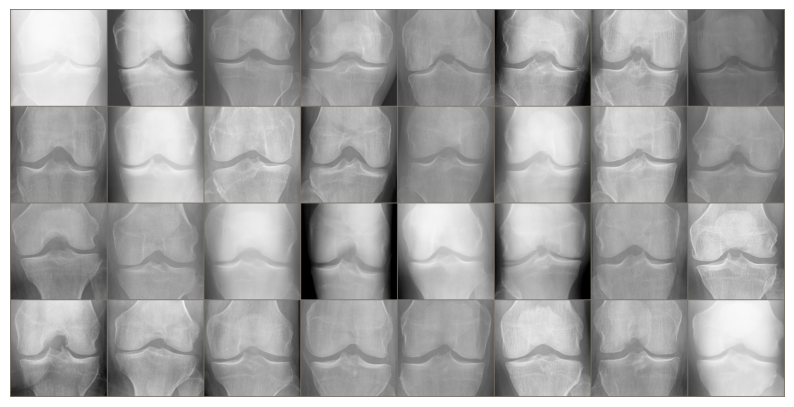

In [7]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()


## Step 8: Load and Modify the Pre-trained ResNet Model
We load a pre-trained ResNet18 model and modify the final layer to match our number of classes.

* We replace the final fully connected layer (`model.fc`) to output the correct number of classes for our dataset.
* `pretrained=True` loads weights trained on ImageNet.

In [8]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s] 


## Step 9: Define Loss Function and Optimizer
We set up the loss function and optimizer for training.

* `CrossEntropyLoss` is suitable for multi-class classification.
* `Adam` optimizer is used with a learning rate of 0.001.

In [9]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Step 10: Train the Model
We train the model for a few epochs.

* We iterate over the training data, compute the loss, perform backpropagation, and update the model weights.
* `model.train()` sets the model to training mode.

In [10]:
# Number of epochs
num_epochs = 25

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [1/25]: 100%|██████████| 181/181 [00:20<00:00,  8.81it/s, loss=1.2756, acc=51.14%]


Epoch [1/25], Loss: 1.1545, Accuracy: 0.5114


Epoch [2/25]: 100%|██████████| 181/181 [00:19<00:00,  9.26it/s, loss=1.0290, acc=57.27%]


Epoch [2/25], Loss: 0.9996, Accuracy: 0.5727


Epoch [3/25]: 100%|██████████| 181/181 [00:19<00:00,  9.09it/s, loss=1.3116, acc=61.87%]


Epoch [3/25], Loss: 0.9113, Accuracy: 0.6187


Epoch [4/25]: 100%|██████████| 181/181 [00:19<00:00,  9.06it/s, loss=0.8789, acc=64.05%]


Epoch [4/25], Loss: 0.8761, Accuracy: 0.6405


Epoch [5/25]: 100%|██████████| 181/181 [00:20<00:00,  8.89it/s, loss=0.8554, acc=64.59%]


Epoch [5/25], Loss: 0.8441, Accuracy: 0.6459


Epoch [6/25]: 100%|██████████| 181/181 [00:20<00:00,  8.79it/s, loss=1.1062, acc=66.25%]


Epoch [6/25], Loss: 0.8113, Accuracy: 0.6625


Epoch [7/25]: 100%|██████████| 181/181 [00:20<00:00,  8.69it/s, loss=0.7218, acc=67.29%]


Epoch [7/25], Loss: 0.7715, Accuracy: 0.6729


Epoch [8/25]: 100%|██████████| 181/181 [00:20<00:00,  8.83it/s, loss=0.6722, acc=68.81%]


Epoch [8/25], Loss: 0.7344, Accuracy: 0.6881


Epoch [9/25]: 100%|██████████| 181/181 [00:20<00:00,  8.85it/s, loss=0.7358, acc=70.79%]


Epoch [9/25], Loss: 0.7021, Accuracy: 0.7079


Epoch [10/25]: 100%|██████████| 181/181 [00:20<00:00,  8.82it/s, loss=0.7911, acc=71.55%]


Epoch [10/25], Loss: 0.6842, Accuracy: 0.7155


Epoch [11/25]: 100%|██████████| 181/181 [00:20<00:00,  8.78it/s, loss=0.5826, acc=72.05%]


Epoch [11/25], Loss: 0.6592, Accuracy: 0.7205


Epoch [12/25]: 100%|██████████| 181/181 [00:20<00:00,  8.80it/s, loss=0.4269, acc=75.49%]


Epoch [12/25], Loss: 0.5969, Accuracy: 0.7549


Epoch [13/25]: 100%|██████████| 181/181 [00:20<00:00,  8.89it/s, loss=0.4792, acc=75.55%]


Epoch [13/25], Loss: 0.5793, Accuracy: 0.7555


Epoch [14/25]: 100%|██████████| 181/181 [00:20<00:00,  8.83it/s, loss=0.6992, acc=77.78%]


Epoch [14/25], Loss: 0.5311, Accuracy: 0.7778


Epoch [15/25]: 100%|██████████| 181/181 [00:20<00:00,  8.84it/s, loss=0.5166, acc=78.19%]


Epoch [15/25], Loss: 0.5329, Accuracy: 0.7819


Epoch [16/25]: 100%|██████████| 181/181 [00:20<00:00,  8.80it/s, loss=0.7293, acc=80.84%]


Epoch [16/25], Loss: 0.4615, Accuracy: 0.8084


Epoch [17/25]: 100%|██████████| 181/181 [00:20<00:00,  8.81it/s, loss=0.6390, acc=81.53%]


Epoch [17/25], Loss: 0.4365, Accuracy: 0.8153


Epoch [18/25]: 100%|██████████| 181/181 [00:20<00:00,  8.84it/s, loss=0.3538, acc=85.53%]


Epoch [18/25], Loss: 0.3716, Accuracy: 0.8553


Epoch [19/25]: 100%|██████████| 181/181 [00:20<00:00,  8.88it/s, loss=0.3290, acc=87.16%]


Epoch [19/25], Loss: 0.3313, Accuracy: 0.8716


Epoch [20/25]: 100%|██████████| 181/181 [00:20<00:00,  8.87it/s, loss=0.3073, acc=87.90%]


Epoch [20/25], Loss: 0.3158, Accuracy: 0.8790


Epoch [21/25]: 100%|██████████| 181/181 [00:20<00:00,  8.83it/s, loss=0.2028, acc=90.13%]


Epoch [21/25], Loss: 0.2560, Accuracy: 0.9013


Epoch [22/25]: 100%|██████████| 181/181 [00:20<00:00,  8.85it/s, loss=0.0832, acc=92.11%]


Epoch [22/25], Loss: 0.2232, Accuracy: 0.9211


Epoch [23/25]: 100%|██████████| 181/181 [00:20<00:00,  8.90it/s, loss=0.4658, acc=92.61%]


Epoch [23/25], Loss: 0.2066, Accuracy: 0.9261


Epoch [24/25]: 100%|██████████| 181/181 [00:20<00:00,  8.83it/s, loss=0.1761, acc=94.46%]


Epoch [24/25], Loss: 0.1541, Accuracy: 0.9446


Epoch [25/25]: 100%|██████████| 181/181 [00:20<00:00,  8.90it/s, loss=0.0601, acc=94.48%]

Epoch [25/25], Loss: 0.1504, Accuracy: 0.9448


## Step 11: Evaluate the Model
We test the model on the test set and evaluate its performance.

* `model.eval()` sets the model to evaluation mode.
* We disable gradient computation with `torch.no_grad()`.
* We collect all predictions and true labels to compute accuracy and generate reports.
* The confusion matrix and classification report provide detailed insights into model performance.

Accuracy on test set: 0.6353
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       639
           1       0.30      0.26      0.28       296
           2       0.64      0.57      0.60       447
           3       0.83      0.69      0.75       223
           4       0.80      0.76      0.78        51

    accuracy                           0.64      1656
   macro avg       0.65      0.62      0.63      1656
weighted avg       0.63      0.64      0.63      1656

Confusion Matrix:
[[530  68  40   1   0]
 [155  76  63   2   0]
 [ 84  92 253  18   0]
 [  3  15  41 154  10]
 [  0   0   1  11  39]]


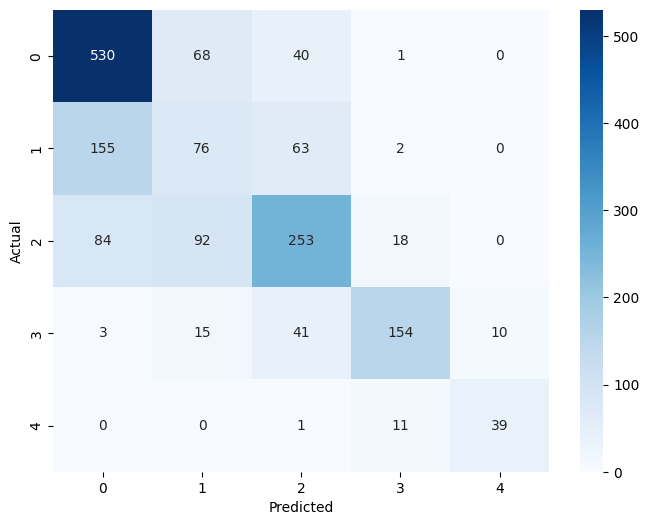

In [11]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [12]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the same transformation as used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to predict a single image
def predict_image(image_path, model, device, classes):
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image = transform(image)

    # Add batch dimension
    image = image.unsqueeze(0).to(device)  # Shape: (1, 3, 224, 224)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image)  # Forward pass
        _, predicted_class = torch.max(output, 1)  # Get predicted class index

    predicted_label = classes[predicted_class.item()]
    
    return predicted_label

# Example usage
image_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/0/9003126L.png"  # Change this to your test image path
predicted_label = predict_image(image_path, model, device, classes)

print(f"Predicted Class: {predicted_label}")


Predicted Class: 0


In [23]:
import torch

model_path = "model.pth"  # Change name if needed
torch.save(model.state_dict(), model_path)

print(f"Model saved as {model_path}")


Model saved as model.pth


In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load ResNet18 with the same modification
model = models.resnet18(pretrained=False)  # Set pretrained=False when loading saved weights
num_ftrs = model.fc.in_features
num_classes = num_classes  # Replace with the actual number of classes
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved weights
model.load_state_dict(torch.load("model.pth"))
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


/tmp/ipykernel_36/2653347000.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


In [28]:
import torch
import torchvision.models as models

# Load the trained PyTorch model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = num_classes  # Set your actual number of classes
model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load("model.pth"))
model.eval()

# Convert to ONNX format
dummy_input = torch.randn(1, 3, 224, 224)  # Assuming input size is (3, 224, 224)
onnx_path = "model.onnx"
torch.onnx.export(model, dummy_input, onnx_path, opset_version=11)

print(f"Model saved in ONNX format as {onnx_path}")


/tmp/ipykernel_36/640108621.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


Model saved in ONNX format as model.onnx


In [29]:
pip install onnx2tf


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.2/446.2 kB 17.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install onnx_graphsurgeon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install sng4onnx


Note: you may need to restart the kernel to use updated packages.


In [36]:
import onnx
from onnx2tf import convert

# Load the ONNX model
onnx_model_path = "model.onnx"  # Ensure this file exists
onnx_model = onnx.load(onnx_model_path)

# Convert to TensorFlow
convert(
    input_onnx_file_path=onnx_model_path,  # Path to the ONNX model
    output_folder_path="tf_model"  # Output directory for the TensorFlow model
)

print("Converted to TensorFlow successfully!")



Model optimizing started ============================================================
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/onnx2tf/onnx2tf.py", line 652, in convert
    result = subprocess.check_output(
  File "/opt/conda/lib/python3.10/subprocess.py", line 421, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/opt/conda/lib/python3.10/subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/opt/conda/lib/python3.10/subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/opt/conda/lib/python3.10/subprocess.py", line 1863, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'onnxsim'


Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model 

W0000 00:00:1740207001.617800      36 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1740207001.617886      36 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Float32 tflite output complete!


W0000 00:00:1740207004.329454      36 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1740207004.329495      36 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Float16 tflite output complete!
Converted to TensorFlow successfully!
